In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import inspect
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [10]:
# To see the columns name and type within the Measurement table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


## Precipitation Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Select only the date and prcp values

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by((Measurement.date).desc()).first()
print(f"Latest date: {last_date[0]}") # last_date returns a result with a str value
last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d') # Converts the last_date result [0] str into a datetime value
year_from_last = last_date - dt.timedelta(days=365) # Calculates the date -365 days
print(f"A year before: {year_from_last.date()}") # year_from_last.date() returns only the date from the datetime value (excludes time)

# Perform a query to retrieve only the date and precipitation scores in the last 12 months
sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= year_from_last).all()

# Save the query results as a Pandas DataFrame
precipitation = pd.DataFrame(queryresult, columns=['Date','Precipitation'])

# Sort the dataframe values by date and set the index to the date column 
precipitation = precipitation.dropna(how='any') # clean up non value entries
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation.set_index("Date", inplace = True)
precipitation.head()

Latest date: 2017-08-23
A year before: 2016-08-23


,Precipitation
Date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15


Text(0, 0.5, 'Precipitation')

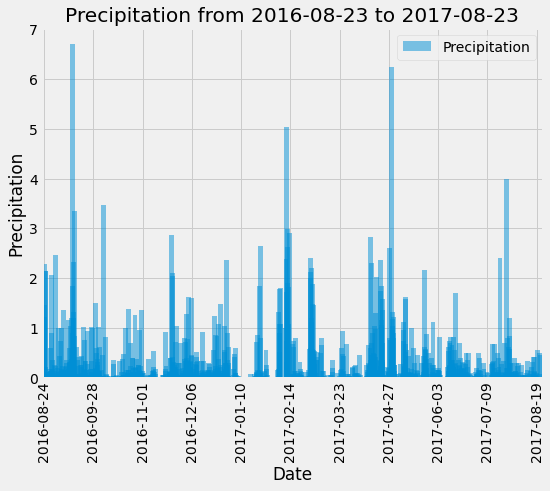

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
plot = precipitation.plot(kind = 'bar', figsize = (8,6), width = 20, alpha=0.5)
plot.xaxis.set_major_locator(ticker.MultipleLocator(200)) # Removes the extra date ticks
plt.title(f"Precipitation from {year_from_last.date()} to {last_date.date()}")
plt.ylabel("Precipitation")

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [14]:
# Design a query to calculate the total number of stations in this dataset
session.query(Measurement.station).distinct().count()

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows)
# List the stations and observation counts in descending order
sel = [Measurement.station,func.count(Measurement.id)]
activestations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Calculate the lowest, highest and average temperature of the most active station
sel = [Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
mostactivestationdata = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first() # Returns the station with the highest number of observations
mostactivestationdata

('USC00519281', 54.0, 85.0, 71.66378066378067)

In [17]:
# Design a query to retrieve the last 12 months of temperature observation data
# Filter by the station with the highest number of observations
# Query the last 12 months of temperature observation data for this station
queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == mostactivestationdata[0]).\
    filter(Measurement.date >= year_from_last).all()

#queryresult generates a list of tuples that needs to be unraveled into the list temperatures
temperatures = list(np.ravel(queryresult))

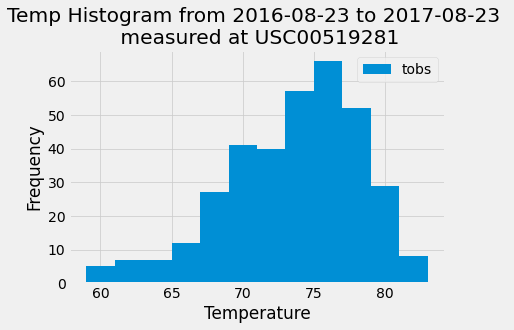

In [18]:
# Plot the results as a histogram with bins = 12
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title(f"Temp Histogram from {year_from_last.date()} to {last_date.date()} \n measured at {mostactivestationdata[0]}")
plt.legend()

## Bonus Challenge Assignment

## Temperature Analysis I

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

In [19]:
#Identify the average temperature in June and Dec at all stations across all available years 

june_avg = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime('%m',Measurement.date) == '06').all()[0][0]
print(f'Avg Temp in June: {june_avg}')

june_query = session.query(Measurement.tobs).\
    filter(func.strftime('%m',Measurement.date) == '06').all()
june_data = list(np.ravel(june_query))

dec_avg = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime('%m',Measurement.date) == '12').all()[0][0]
print(f'Avg Temp per station in December: {dec_avg}')

dec_query = session.query(Measurement.tobs).\
    filter(func.strftime('%m',Measurement.date) == '12').all()
dec_data = list(np.ravel(dec_query))

Avg Temp in June: 74.94411764705882
Avg Temp per station in December: 71.04152933421226


In [20]:
# Use a paired t-test to determine whether the temp avg in June and Dec are statistically different from each other
print (len(june_data))
print (len(dec_data))
stats.ttest_ind(june_data, dec_data, equal_var=False) 
# The t-test result gives a p<0.001, which shows that the avg temperature in June is significantly higher than the temperature in December.

1700
1517


Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

## Temperature Analysis II

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use the previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startdate = dt.date(2017,1,1)
enddate = dt.date(2017,1,7)
tempresult = calc_temps(startdate,enddate)[0]
tempresult

(62.0, 68.36585365853658, 74.0)

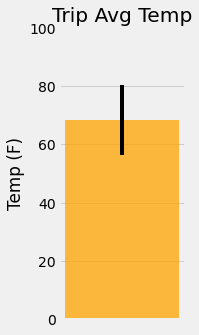

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [0]
y_pos = [tempresult[1]]
error = [(tempresult[2] - tempresult[0])]

plt.figure(figsize=(2, 5))
plt.bar(x_pos,y_pos,color='orange', yerr=error, alpha = 0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

## Daily Rainfall Average

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
queryresult = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= startdate).\
    filter(Measurement.date <= enddate).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
rainfall_perstation = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation','PrcpSum'])
rainfall_perstation

,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.61
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.60
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.60
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.35
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.20
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

startdate = dt.date(2017,1,1)
enddate = dt.date(2017,1,7)

# Use the start and end date to create a range of dates
# Loop through the list of %m-%d strings and calculate the normals for each date
tripdates = []
normals = []
while (startdate <= enddate):
    tripdates.append(startdate)
    querydate = dt.datetime.strftime(startdate,'%m-%d') # Stip off the year and save a list of %m-%d strings
    normals.append(list(np.ravel(daily_normals(querydate))))
    startdate = dt.date(startdate.year, startdate.month, startdate.day+1)

normals

[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0]]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
normals_df['Date'] = tripdates
normals_df = normals_df.set_index("Date")
normals_df

,tmin,tavg,tmax
Date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0


Text(0, 0.5, 'Temp (F)')

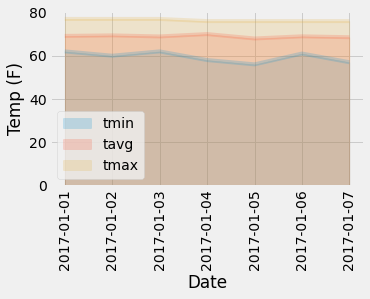

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, alpha = 0.2, figsize=(5, 3))
plt.xticks(rotation=90)
plt.ylabel("Temp (F)")